## 丢弃法（Dropout）

### 动机
一个好的模型需要**对输入数据的扰动鲁棒**
- 使用有噪音的数据等价于Tikhonov正则（等价于$L_2$正则），引入噪音可以增加数据多样性，进而减少模型的过拟合，具有类似于正则化的效果
- **丢弃法**：在**层之间**加入噪音——也是一种**正则化**

### 无差别的加入噪音
- 对$x$加入噪音$\mathbf{x'}$，且（无偏）
$$
\mathbb{E}[\mathbf{x'}] = \mathbf{x}
$$
- 丢弃法对每个元素进行如下扰动
$$
x'_i =
\begin{cases} 
0, & \text{with probability } p \\
\frac{x_i}{1 - p}, & \text{otherwise} 
\end{cases}
$$

### 使用丢弃法
- 通常将丢弃法**作用在隐藏全连接层的输出上**  
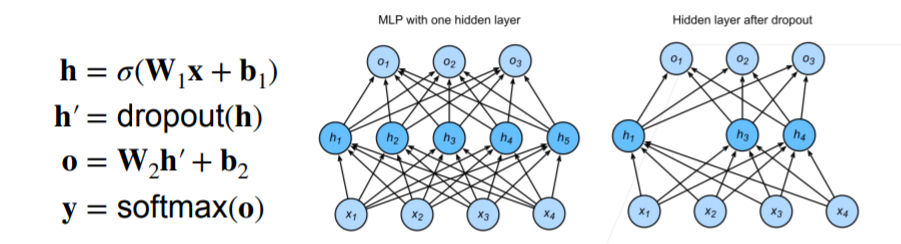

### 推理中的丢弃法
- 正则项**只在训练中使用**：影响**模型参数**的更新
- 在推理过程中，丢弃法直接返回输入
$$
\mathbf{h} = \text{dropout}(\mathbf{h})
$$
这样也能保证确定性的输出

### 总结
- 丢弃法将一些**输出项随机置0**来**控制模型复杂度**
- 常作用在**多层**感知机的**隐藏层输出**上
- **丢弃概率**是控制模型复杂度的**超参数**（最常见的：0.5，0.9，0.1）

### 重新审视过拟合
**偏差-方差权衡（bias-variance tradeoff）**
- 偏差：衡量的是模型预测的期望值和真实值之间的**差距**，反应了模型的**系统性误差**——偏差是由于模型假设错误或过于简单引起的
- 方差：衡量的是模型的预测岁训练数据变化的**敏感程度**——高方差模型往往**过拟合**训练数据
- 噪音：是数据本身带来的，模型无法通过优化来消除噪音
- **低偏差-高方差**：复杂的模型（如深度神经网络）
- **高偏差-低方差**：简单的模型（如线性回归）
- **偏差-方差权衡是机器学习中选择模型复杂度时面临的一个核心问题**  
这个权衡的核心目标——**在保证模型不欠拟合的同时，尽量减少过拟合**，使得模型在训练集和测试集上都能有较好的表现


### Dropout在深度学习中训练和测试时的不同用法
- 训练时：一种常用的**正则化方法**，通过每次前向传播中随机丢弃一定比例的神经元，迫使模型的不同部分独立地学习特征  
**目的**是减少模型对某些神经元或特定特征的依赖，进而提高模型的泛化能力，防止过拟合
- 训练时：**不再使用Dropout，即所有神经元都会被激活  
**原因**：模型在测试时应该尽可能利用所学到的特征，而不再随机丢弃神经元，确保模型做出最稳定的预测
- 例外情况：**蒙特卡罗Dropout**，估计神经网络**不确定性**的一种方法

In [2]:
from IPython import display

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


def load_data_fashion_mnist(batch_size, resize=None, num_workers=0):
    """
    下载Fashion-MNSIT数据集，然后将其加载到内存中
    """
    trans = [transforms.ToTensor()]  # 列表
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='.\data', train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='.\data', train=False, transform=trans, download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=num_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=num_workers))

## 从0开始实现

**实现`dropout_layer`函数**，以`dropout`的概率丢弃张量输入`X`中的元素
- 要实现单层的暂退法函数，从均匀分布中抽取样本，样本数与这层神经网络的维度一致
- 然后保留那些对应样本大于$p$的节点，剩下的丢弃
- 不用`X[mask] = 0`原因：对GPU和CPU都不是很好，**乘法远远比选一个元素来的快**

In [1]:
import torch
import torchvision

from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1 
    if dropout == 1:
        return torch.zeros(X.shape) # torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1. - dropout)

In [3]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 1.))
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.7))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.0000,  0.0000,  0.0000, 10.0000,  0.0000, 16.6667,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 33.3333, 36.6667,  0.0000, 43.3333,  0.0000,  0.0000]])


### 定义模型参数
使用`Fashion-MNIST`数据集，定义**具有两个隐藏层**的多层感知机，每个隐藏层包含256个单元

In [4]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型
- 将暂退法应用于每个隐藏层的输出（激活函数后）
- 为每一层**分别**设置暂退概率：**在靠近输入层的地方设置调低的暂退概率**
- 暂退法只在训练期间有效

- `class Net(nn.Module)`：`Net`**继承**自`nn.Module`，是pytorch中构建神经网络的**标准方式**
- `is_training`：控制模型是**训练模式**还是**推理模式**，**只有训练模式才使用dropout**
- `super(Net, self).__init__()`调用了父类的初始化方法:会返回`nn.Module`类的一个实例，这允许子类`Net`访问并调用`nn.Module`中的方法  
`super()`用于调用父类的方法
- `self.lin1`的输入张量形状为`(batch_size, input_shape)`


In [5]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, 
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        # 层定义
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        # 只有训练模式使用dropout
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### 训练和测试

- 出现错误：`RuntimeError: DataLoader worker`，要将**多进程**设置为1

In [6]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)

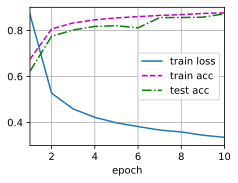

In [7]:
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 简洁实现
对于深度学习框架的高级API，只需**在每个全连接层之后添加一个`Dropout`层**
- 注意还有**初始化**这一步

In [8]:
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256), nn.ReLU(), nn.Dropout(dropout1),
                    nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout2),
                    nn.Linear(256, 10)
                   )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

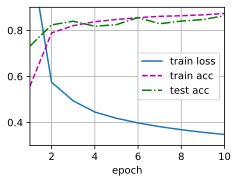

In [9]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 小结

* 暂退法在前向传播过程中，计算每一内部层的同时丢弃一些神经元。
* 暂退法可以避免过拟合，它通常与控制权重向量的维数和大小结合使用的。
* 暂退法将活性值$h$替换为具有期望值$h$的随机变量。——将每个神经元的激活值替换为一个**带有一定随机性的变量**，期望值与原本激活值相同
* 暂退法仅在训练期间使用。

### 练习

1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。


### 回答
1. 交换两层的暂退法概率会导致结果变差
- pytorch中`torch.optim.SGD`支持**参数组**的方式

In [49]:
import torch
import numpy as np

from torch import nn
from d2l import torch as d2l

def set_net(dropout1, dropout2):
    net = nn.Sequential(nn.Flatten(),
                        nn.Linear(784, 256), nn.ReLU(), nn.Dropout(dropout1),
                        nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout2),
                        nn.Linear(256, 10)
                       )
    return net

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


class myAnimator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4.5, 3.5),wspace=0.5, hspace =0.8):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        
        self.config_axes =lambda axesnx,axesny: d2l.set_axes(self.axes[axesnx,axesny], xlabel, ylabel, xlim, ylim, xscale, yscale, legend) if axesnx==0&axesny==0 else d2l.set_axes(self.axes[axesnx,axesny], xlabel, ylabel, xlim, ylim, xscale, yscale,[])
                    
        d2l.plt.subplots_adjust(wspace =wspace, hspace =hspace)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self,axesnx,axesny, x, y,title=None):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[axesnx,axesny].cla()
        if title:
            self.axes[axesnx,axesny].set_title(title)
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[axesnx,axesny].plot(x, y, fmt)
        self.config_axes(axesnx,axesny)
        d2l.display.display(self.fig)
        d2l.display.clear_output(wait=True)


def changed_dropout(dropout1_list, dropout2_list, batch_size=256, lr=0.5,
                    wd=None, xlim=[1, 10], ylim=[0.3, 0.9], 
                    figsize=(15, 10),wspace=0.2, hspace =0.3,
                    num_epochs=10, is_show=True):
    num_dropout1, num_dropout2 = len(dropout1_list), len(dropout2_list)
    train_iter, test_iter = load_data_fashion_mnist(batch_size)

    if is_show==True:
        if (num_dropout1 == 1) & (num_dropout2 == 1):
                animator = d2l.Animator(xlabel='epoch',ylabel='Y', xlim=xlim, ylim=ylim,
                                legend=['train loss', 'train acc', 'test acc'],figsize=figsize)
        else:
                animator = myAnimator(xlabel='epoch',ylabel='Y', xlim=[1,num_epochs], ylim=ylim,
                                legend=['train loss', 'train acc', 'test acc'],nrows=num_dropout1, ncols=num_dropout2,figsize=figsize,wspace=wspace, hspace =hspace)
            
    train_loss_list = np.zeros((num_dropout1, num_dropout2, num_epochs))
    train_acc_list = np.zeros((num_dropout1, num_dropout2, num_epochs))
    test_acc_list = np.zeros((num_dropout1, num_dropout2, num_epochs))

    for i in range(num_dropout1):
        for j in range(num_dropout2):
            dropout1, dropout2 = dropout1_list[i], dropout2_list[j]
            net = set_net(dropout1, dropout2)
            net.apply(init_weights)
            loss = nn.CrossEntropyLoss(reduction='none')
            
            # 根据是否需要来设置权重衰减
            if wd == None:
                trainer = torch.optim.SGD(net.parameters(), lr=lr)
            else:
                paramlist = []
                for m in net:
                    if type(m) == nn.Linear:
                        paramlist.append({'params':m.weight, 'weight_decay':wd})
                        paramlist.append({'params':m.bias})
                trainer = torch.optim.SGD(paramlist, lr=lr)
    
            # for epoch in range(num_epochs):
            #     train_epoch_ch3(net, train_iter, loss, trainer)
    
            # # 记录最终的训练和测试损失
            # train_loss = evaluate_loss(net, train_iter, loss)
            # test_loss = evaluate_loss(net, test_iter, loss)
            # train_loss_list.append(train_loss)
            # test_loss_list.append(test_loss)
            
            for epoch in range(num_epochs):
                train_metrics = train_epoch_ch3(net, train_iter, loss, trainer)
                test_acc = evaluate_accuracy(net, test_iter)
                train_loss_list[i, j, epoch], train_acc_list[i,j,epoch], test_acc_list[i,j,epoch] = train_metrics[0], train_metrics[1], test_acc
                if is_show == True:
                    if num_dropout1 == 1 and num_dropout2 == 1:
                        animator.add(epoch + 1, train_metrics + (test_acc, ))
                    else:
                        animator.add(i, j, epoch + 1, train_metrics + (test_acc,), title=f"dropout1:{dropout1},dropout2:{dropout2}")
    
            if is_show == True:
                animator.X, animator.Y = None, None  # 重置`animator`对象中的`X`和`Y`
            train_loss, train_acc = train_metrics
        
    return train_loss_list, train_acc_list, test_acc_list

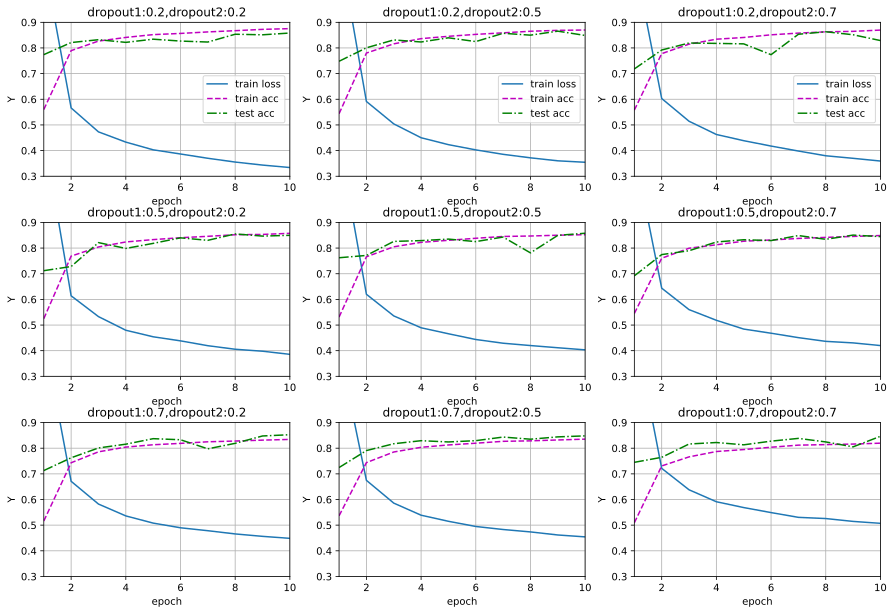

In [35]:
dropout1_list, dropout2_list = [0.2, 0.5, 0.7], [0.2, 0.5, 0.7]
train_loss_list, train_acc_list, test_acc_list = changed_dropout(dropout1_list, dropout2_list)

`np.vstack`：用于**垂直堆叠**多个数组，沿着第一个轴进行拼接（其他维度保持不变）
- **除了第一个轴大小可以不同，其他维度大小必须一致**

#### `train_loss_list`
是三层NumPy数组：
- 第一层（维度0）：不同`dropout1`组合，长度为`num_dropout1`
- 第一层（维度1）：不同`dropout2`组合，长度为`num_dropout2`
- 第三层（维度3）：训练的`epoch`数，表示每个组合进过`num_epoch`轮训练后记录的结果

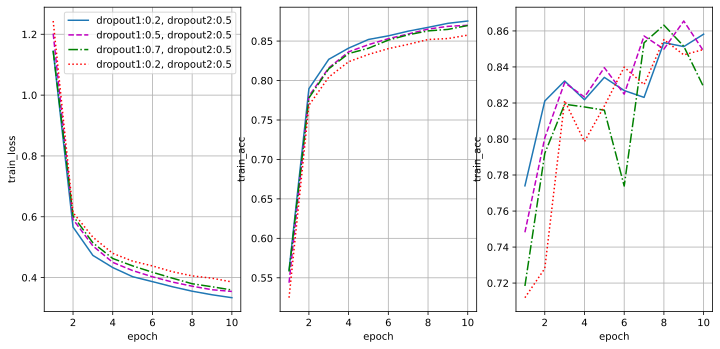

In [38]:
d2l.plt.figure(figsize=(12, 5.5))
d2l.plt.subplot(131)
d2l.plot(list(range(1, 11)), 
         np.vstack([train_loss_list[i, :, :] for i in range(len(dropout1_list))]),
         'epoch', 'train_loss',
         legend=[f'dropout1:{dropout1}, dropout2:{dropout2}' for dropout1 in dropout1_list for dropout2 in dropout2_list]
        )
d2l.plt.subplot(132)
d2l.plot(list(range(1, 11)),
         np.vstack([train_acc_list[i, :, :] for i in range(len(dropout1_list))]),
         'epoch', 'train_acc',
         # legend=[f'dropout1:{dropout1}, dropout2:{dropout2}' for dropout1 in dropout1_list for dropout1 in dropout2_list]
        )
d2l.plt.subplot(133)
d2l.plot(list(range(1, 11)),
         np.vstack([test_acc_list[i, :, :] for i in range(len(dropout1_list))]),
         'epoch', 'train_acc',
         # legend=[f'dropout1:{dropout1}, dropout2:{dropout2}' for dropout1 in dropout1_list for dropout1 in dropout2_list]
        )


2. 增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。
- 没使用`dropout`会出现loss值突然上升的情况

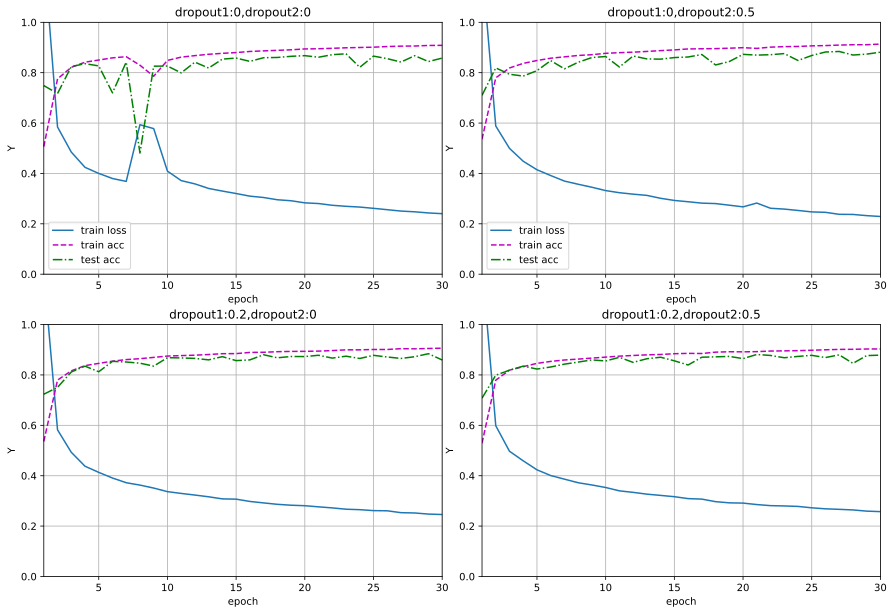

In [40]:
num_epochs = 30
dropout1_list, dropout2_list = [0, 0.2], [0, 0.5]
train_loss_list, train_acc_list, test_acc_list = changed_dropout(dropout1_list, dropout2_list, num_epochs=num_epochs, wspace=0.1, hspace =0.2, ylim=[0,1])

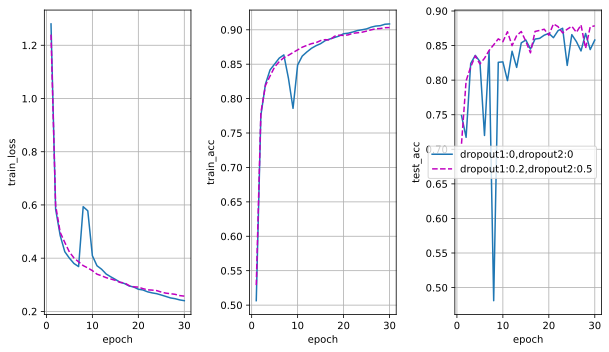

In [42]:
d2l.plt.figure(figsize=(10, 5.5)) 
d2l.plt.subplot(131)
d2l.plot(list(range(1,num_epochs+1)),np.vstack((train_loss_list[0,0,:],train_loss_list[1,1,:])),'epoch', 'train_loss')
d2l.plt.subplot(132)
d2l.plot(list(range(1,num_epochs+1)),np.vstack((train_acc_list[0,0,:],train_acc_list[1,1,:])),'epoch', 'train_acc')
d2l.plt.subplot(133)
d2l.plot(list(range(1,num_epochs+1)),np.vstack((test_acc_list[0,0,:],test_acc_list[1,1,:])),'epoch', 'test_acc',
                     legend=['dropout1:0,dropout2:0','dropout1:0.2,dropout2:0.5'])
d2l.plt.subplots_adjust(wspace =0.4, hspace =0)

3. 当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。
- **还没弄明白代码**

In [44]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.like) < dropout).float()
    return mask * X / (1. - dropout)

dropout0 = dropout_layer(torch.ones(1, dtype=torch.float32), 0)
dropout0d5 = dropout_layer(torch.ones(1, dtype=torch.float32), 0.5)
var_dropout0 = torch.empty(1)
var_dropout0d5 = torch.empty(1)

for _ in range(1000):
    dropout0d5=torch.cat([dropout0d5,dropout_layer(torch.ones(1,dtype = torch.float32), 0.5)])
    dropout0=torch.cat([dropout0,dropout_layer(torch.ones(1,dtype = torch.float32), 0)])
    
    var_dropout0d5=torch.cat([var_dropout0d5,torch.var(dropout0d5).reshape(1)])
    var_dropout0=torch.cat([var_dropout0,torch.var(dropout0).reshape(1)])

d2l.plot(torch.arange(2,1003)[2:-1:50], [var_dropout0.detach()[2:-1:50],var_dropout0d5.detach()[2:-1:50]],
         legend=['dropout=0','dropout=0.5'])
d2l.plt.xlabel("X");
d2l.plt.ylabel("var");

AttributeError: 'Tensor' object has no attribute 'like'

4. 为什么在测试时通常不使用暂退法?
- 训练时使用暂退法是为了防止模型过拟合（参数的确定过程），提高网络泛化能力
- 测试时我们希望可以用上所有的参数，减少参数反而会**影响网络稳定性**

5. 以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

答：同时使用暂退法和权重衰退结果好于只使用其中一种
- 只使用暂退法——进行10次循环，计算最终的**平均值**
- 只使用权重衰退——不需要循环
- 同时使用——进行10次循环

only dropout train loss 0.3484, train acc0.8719, test acc 0.8489


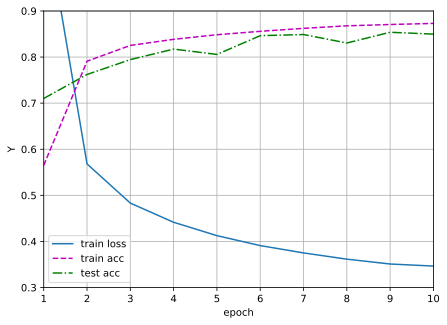

In [47]:
# 只使用暂退

# 初始化，用于累加
train_loss_1, train_acc_1, test_acc_1 = 0., 0., 0.
for i in range(10):
    is_show = False if i < 9 else True
    train_loss_list, train_acc_list, test_acc_list = changed_dropout(dropout1_list=[0.2], dropout2_list=[0.5], figsize=(7, 5), is_show=is_show)
    train_loss_1 += train_loss_list[-1][-1][-1] / 10
    train_acc_1 += train_acc_list[-1][-1][-1] / 10
    test_acc_1 += test_acc_list[-1][-1][-1] / 10

print('only dropout train loss {:.4f}, train acc{:.4f}, test acc {:.4f}'.format(train_loss_1, train_acc_1, test_acc_1))


dropout and weight decay, train loss 0.3555, train acc0.8696, test acc 0.8466


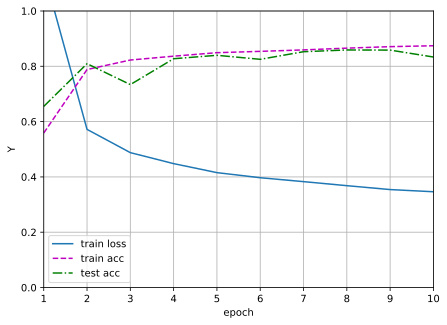

In [50]:
# 同时使用

train_loss_2, train_acc_2, test_acc_2 = 0., 0., 0.
for i in range(10):
    is_show = False if i < 9 else True
    train_loss_list, train_acc_list, test_acc_list = changed_dropout(dropout1_list=[0.2], dropout2_list=[0.5], wd=1e-4, ylim=[0, 1], figsize=(7, 5), is_show=is_show)
    train_loss_2 += train_loss_list[-1][-1][-1] / 10
    train_acc_2 += train_acc_list[-1][-1][-1] / 10
    test_acc_2 += test_acc_list[-1][-1][-1] / 10
print('dropout and weight decay, train loss {:.4f}, train acc{:.4f}, test acc {:.4f}'.format(train_loss_2, train_acc_2, test_acc_2))


only weight decay, train loss 0.3274, train acc0.8776, test acc 0.8200


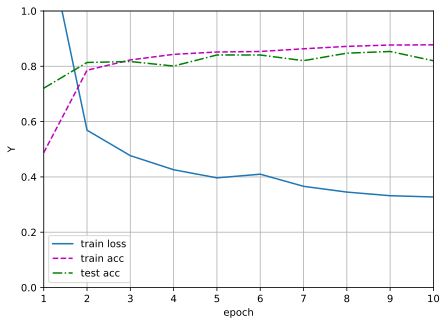

In [51]:
# 只使用权重衰退

train_loss_list_3, train_acc_list_3, test_acc_list_3 = changed_dropout(dropout1_list=[0.], dropout2_list=[0.], wd=1e-4, ylim=[0, 1], figsize=(7, 5), is_show=True)
print('only weight decay, train loss {:.4f}, train acc{:.4f}, test acc {:.4f}'.format(train_loss_list_3[-1][-1][-1], train_acc_list_3[-1][-1][-1], test_acc_list_3[-1][-1][-1]))


6. 如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？
- 权重矩阵稀疏化——将会改变网络的优化路径，因为每次迭代中，优化器都只能使用部分权重进行参数更新
- 可能破怪收敛——随机丢弃权重会使权重更新的路径更加不稳定，可能使模型难以收敛，或者需要更多的训练轮次才能找到一个合理的解  
通常，神经网络需要稳定、可连续更新的权重，以保证收敛到最优解

**总结**：
- **在激活值上使用Dropout**：能够有效降低过拟合，因为其迫使网络的不同部分独立地学习特征，增加了网络的鲁棒性和泛化能力  
~是让部分神经元的输出暂时失效
- **权重矩阵上不使用Dropout**：权重的更新是通过**反向传播**进行的，而权重的随机置0会破坏此过程，导致模型难以收敛  
~使得神经元间的连接时有时无

7. 发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法。
- **对每个ReLU输出加上一个 高斯噪音**——做一个两层隐藏层的+**只有训练**才使用噪音

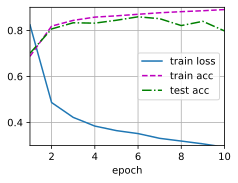

In [58]:
def noise_layer(X, rate=0.1):
    return X + rate * torch.randn(X.shape)

class Net_gauss(nn.Module):
    def __init__(self, num_inputs=784, num_hidden1=256, num_hidden2=256,
                 num_outputs=10, is_training=True
                ):
        super(Net_gauss, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        if self.training == True:
            H1 = noise_layer(H1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = noise_layer(H2)
        out = self.lin3(H2)
        return out

net = Net_gauss()
num_epochs, batch_size, lr = 10, 256, 0.5
loss = nn.CrossEntropyLoss(reduction='none')
# trainer_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


**tick**:
- 可以吧模型弄得复杂一点，通过正则化来控制模型复杂度
- 可以把隐藏层稍微设大一点，dropout率设大一点，可能比不用dropout而隐藏层小效果要好
- **Dropout主要对全连接层使用**
- dropout的介入有可能使参数收敛更慢，从期望上讲有没有dropout差不多，lr对期望和方差敏感一点——经验上讲，引入dropout不用相应对lr进行改变的

### 以下是练习过程
- `transforms.Compose`用于将多个图像转换操作串联在一起
- `transforms.ToTenser()`将图像转换为张量，同时将像素值从[0, 255]范围缩放到[0.0, 1.0]
- `output`是模型的预测分数或概率，`y`是真是的类别标签——组要先`torch.max(output, 1)`获取`predicted`
- `torch.max(output, 1)`**返回两个值**：最大值和对应的**索引**；且在第一维度取最大值
- pytorch中的`.sum()`返回的是一个**标量张量**

In [ ]:
batch_size = 256
transform = transforms.Compose([transformers.ToTensor()])
train_data = datasets.FashionMNSIT(root='.\data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='.\data', train=False, download=True, transform=transform)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = troch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

def train(net, train_iter, test_iter, num_epochs, lr):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            opimizer.zero_grad()
            output = net(X.reshape(-1, 784))
            l = loss(output, y)
            l.mean().backward()
            opimizer.step()

        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_iter:
                output = net(X.reshape(-1, 784))
                _, predicted = torch.max(output, 1)
                correct += (predicted == y).float().sum().item() # 可以直接省去`.flaat()`
                total += y.numel()
        print(f'Epoch {epoch + 1}, Accuracy:{correct / total * 100:.2f}%')        